# Removal continuum
It helps us to eliminate a signal, which "contaminates" or displaces the data.

In this case, this is ready in our datas (process did by ALMA), but I applied again, for obtained the value of RMS. To avoid any modification to the spectrum, I apply a polynomial of order ZERO, in addition, I keep the range used by alma to avoid emission.

----------------------------- IMPORT PACKAGES TO USE ------------------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from spectral_cube import SpectralCube
from astropy.coordinates import SpectralQuantity
from astropy.io import fits
from tqdm import tqdm
from astropy.coordinates import SkyCoord, SkyOffsetFrame
from astropy.wcs import WCS
from astropy.stats import mad_std
import dask.array as da

------------------------------------ WRITE DIFFERENT PARAMETERS TO USE --------------------------------------

In [276]:
# Define the filenames of the two data cubes

file1 = 'C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/CORRECT/CF+/nopbcor/CF+_N159_sci_inK_NOPBCor.fits'
#file1 = 'C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/CORRECT/CII/CII_N159_SPAT_RES.fits'
#file1 = 'C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/FILES/CF+_DATAS/member.uid___A001_X3621_X1a6a.N159-13CII_sci.spw26.cube.I.pbcor.fits'   #CUBE .pbcor

# Open the FITS files
cube = SpectralCube.read(file1, format='fits', use_dask=True)
print(cube.header)

# Define the frequency (in Hz) where we have the emission line
# CF+ Emission
freq1_CF = 102.51146 * u.GHz
freq2_CF = 102.47862 * u.GHz
# Other line
freq1_nn = 102.47203 * u.GHz
freq2_nn = 102.45554 * u.GHz

print(f'Frequencies to use in CF: {freq1_CF, freq2_CF}')
print(f'Frequencies to use in other line: {freq1_nn, freq2_nn}')

# Range of velocities for generate the polinomial fit
fit_range_km_s = (200., 275.) # Rango para el ajuste lineal 
#fit_range_km_s = (274, 436) 

# Define the spatial pixel to obtain the intensity
x = 62
y = 72

# Define the coordinate to obtain the spectrum 
# coord = SkyCoord("05h39m36.0919s", "-69d45m41.651s", frame='icrs')
coord = SkyCoord("05h39m36.5s", "-69d45m35.00s", frame='icrs')
# RA y Dec en formato sexagesimal (HH:MM:SS, DD:MM:SS)
ra_str = coord.ra.to_string(unit=u.hour, sep=':', precision=3, pad=True)   # '05:39:36.675'
dec_str = coord.dec.to_string(unit=u.deg, sep=':', precision=3, alwayssign=True, pad=True) # '-69:46:00.260'
print(ra_str, dec_str)

# Define the output filenames
#outputfile = 'C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/CORRECT/CF+/SustractCont/CF+_N159_sci_VELAXIS_CONT_REM.fits'
outputfile_rms = 'C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/RMS/CF+_N159_sci_RMS_NOPBCOR_inK.fits'

# Polinomial order
order = 0

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3                                                  NAXIS1  =                  120                                                  NAXIS2  =                  128                                                  NAXIS3  =                 2043                                                  BMAJ    =   4.442253420057E-03                                                  BMIN    =   3.226777089219E-03                                                  BPA     =  -8.550686982140E+01                                                  BTYPE   = 'Intensity'                                                           OBJECT  = 'N159-13CII'                                                          BUNIT   = 'K       '           / Brightness (pixel) unit                        ALTRVAL =   5.990705566226E+05 /Alternat

------------------------------------------ CHANGE THE CELESTIAL COORDINATES TO PIXEL ------------------------------

In [279]:
# Transform to pixel (NECESSARY IN PLOT)
# Obtain the integrated intensity in each position of cubes from files
wcs_cel = cube.wcs.celestial
x1, y1 = wcs_cel.world_to_pixel(coord)

# Redondear y convertir a enteros
pix_x, pix_y = int(np.rint(x1)), int(np.rint(y1))
print(f'Pixel coordinates rounded (from cube.wcs): x={pix_x}, y={pix_y}')



Pixel coordinates rounded (from cube.wcs): x=61, y=75


------------------------------------------- EXTRACT THE NECESSARY INFORMATION ------------------------------------------

In [280]:
# Obtain the essential information from the cubes

UNIT = cube.header['CUNIT3']
RESTFRQ = cube.header['RESTFRQ'] * u.Hz  # Rest frequency in Hz
#RESTFRQ = 1900.5369 * u.GHz  # Rest frequency in Hz, used in C+
CRVAL = cube.header['CRVAL3'] * u.km/u.s # Value of the third axis
CRPIX = cube.header['CRPIX3']  # Reference pixel of the third axis
CDELT = cube.header['CDELt3'] * u.km/u.s # Coordinate increment at reference point

print('UNIT in cube:', UNIT)
print('RESTFRQ in cube:', RESTFRQ)
print('CRVAL in cube:', CRVAL)
print('CRPIX in cube:', CRPIX)
print('CRDELT in cube:', CDELT)
print('--'*50)

RESTFRQ = RESTFRQ.to(u.GHz)  # Convert to GHz
print('RESTFRQ:', RESTFRQ)
print('--'*50)

C = const.c.to(u.km/u.s)  # Speed of light in km/s
print('Speed of light:', C)
print('--'*50)

# Check the number of channels in the cubes
nchan = cube.shape[0]
print('Number of channels in cube:', nchan)
print('--'*50)

# Transform values of frequency to velocity
restfreq = RESTFRQ

vel1_CF = SpectralQuantity(freq1_CF, doppler_rest=restfreq, doppler_convention="radio").to(u.km/u.s)
vel2_CF = SpectralQuantity(freq2_CF, doppler_rest=restfreq, doppler_convention="radio").to(u.km/u.s)

vel1_nn = SpectralQuantity(freq1_nn, doppler_rest=restfreq, doppler_convention="radio").to(u.km/u.s)
vel2_nn = SpectralQuantity(freq2_nn, doppler_rest=restfreq, doppler_convention="radio").to(u.km/u.s)

print(f'Value of vel to use in CF: {vel1_CF.value, vel2_CF.value}')
print(f'Value of vel to use in other line:{vel1_nn, vel2_nn}')

UNIT in cube: Hz
RESTFRQ in cube: 102587476000.0 Hz
CRVAL in cube: 102382477059.2 km / s
CRPIX in cube: 1.0
CRDELT in cube: 122083.4000092 km / s
----------------------------------------------------------------------------------------------------
RESTFRQ: 102.58747600000001 GHz
----------------------------------------------------------------------------------------------------
Speed of light: 299792.458 km / s
----------------------------------------------------------------------------------------------------
Number of channels in cube: 2043
----------------------------------------------------------------------------------------------------
Value of vel to use in CF: (np.float64(222.14235475812436), np.float64(318.11103148743587))
Value of vel to use in other line:(<SpectralQuantity 337.36905766 km / s>, <SpectralQuantity 385.55795776 km / s>)


In [281]:
# Obtain the velocity axis and frequency axis
#index = np.arange(1, nchan + 1 ) # Aggregate (+1) because nchan2 print 1 to 728
#VEL = CRVAL + (index - CRPIX) * CDELT #Create the velocity axis
VEL = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=RESTFRQ).spectral_axis
#print('Index:', index)
print('---------------------------')
print('Velocity:', VEL)


---------------------------
Velocity: [ 599.07055662  598.71379102  598.35702542 ... -128.7312702  -129.08803581
 -129.44480141] km / s


In [282]:
# Create the frequency axis
FREQ = cube.with_spectral_unit(u.Hz, rest_value=RESTFRQ).spectral_axis.to(u.GHz)  # Convert to GHz
print('Frequency:', FREQ)

Frequency: [102.38247706 102.38259914 102.38272123 ... 102.6315272  102.63164928
 102.63177136] GHz


---------------------------------- CREATION OF MASKING IN EMISSION -----------------------------------------

### Define two velocities masks

- range for the first mask: 225 to 245 km/s, that correspond the range of peak emission CF+
- range for the second mask: 338 to 372 km/s, that correspond other peak emission that I dont know the origin

### In this process

I calculate the RMS using a pre-emission velocity range.
The Spectral Resampled cube have 729 (599 km/s) channel, where the emission is between the velocity 221 to 250 km/s.

With the defined range, the integrated intensity curves are obtained, a zero order polynomial is applied and with the residual obtained, the RMS value for each channel is obtained.


In [283]:
## Rango de velocidades para las máscaras que definen la emission
#mask_ranges_km_s = [(vel1_CF.value, vel2_CF.value), (vel1_nn.value , vel2_nn.value)]
mask_ranges_km_s = [(220, 250)]  # Define the ranges of velocities windows km/s (ALMA, YOKO)
print('Mask ranges in km/s:', mask_ranges_km_s)

Mask ranges in km/s: [(220, 250)]


#### The model is fitting in the range more or less 4 time the width of the peak.

 - CF+ emission range velocity: 177 to 294 km/s, width of peak is app 11 velocities.
 - Other emission range velocity: 274 to 436 km/s, width of peak is app 16 velocities.

In [284]:
vel_fit_min, vel_fit_max = fit_range_km_s
mask_fit_range = (VEL >= vel_fit_min * u.km/u.s) & (VEL <= vel_fit_max * u.km/u.s)

full_mask_exclude = np.zeros(len(VEL), dtype=bool)
for v_min, v_max in mask_ranges_km_s:
    mask_plot = (VEL >= v_min * u.km/u.s) & (VEL <= v_max * u.km/u.s)
    full_mask_exclude |= mask_plot

include_mask = mask_fit_range & ~full_mask_exclude
include_chans = np.where(include_mask)[0]
velocities_to_fit = VEL[include_chans]

print(f"Channels para ajuste: {len(include_chans)} de {nchan} totales.")
if len(include_chans) <= order:
    print("Error: No hay suficientes canales para el ajuste polinomial.")
    exit()


Channels para ajuste: 126 de 2043 totales.


------------------------------- Generate the continuum substraction ----------------------------------------

In [285]:
# Initialize a new NumPy array to store the continuum-subtracted data
# It will have the same shape as the original cube and be filled with NaNs initially.
continuum_subtracted_data = np.full(cube.shape, np.nan, dtype=np.float32)
# Get spatial dimensions (Y, X)
n_y, n_x = cube.shape[1], cube.shape[2]
print(n_y, n_x)
# Initialize an array to store RMS values from the continuum-only regions for each pixel
# This will be used for the global RMS map and histogram
rms_map = np.full((n_y, n_x), np.nan)


128 120


In [286]:
import numpy as np
print(f"Cubo: {cube.shape}, tamaño estimado: {cube.size * 8 / 1e6:.2f} MB")


Cubo: (2043, 128, 120), tamaño estimado: 251.04 MB


In [287]:
from tqdm import tqdm

for y in tqdm(range(n_y), desc="Processing"):
    for x in range(n_x):
        # Extract the spectrum for this pixel
        intensity1 = cube[:, y, x].value
        
        # Get intensities for fitting
        intensities_to_fit = intensity1[include_chans]
        
        # Fit the polynomial if enough data
        if len(intensities_to_fit) > order:
            poly_coeff1 = np.polyfit(velocities_to_fit.value, intensities_to_fit, deg=order)
            fitted_line1 = np.polyval(poly_coeff1, velocities_to_fit.value)
            
            # Compute residuals on fitted points for RMS
            residuals_fitted_points1 = intensities_to_fit - fitted_line1
            
            # Calculate RMS
            new_rms1 = np.sqrt(np.mean(residuals_fitted_points1**2))
            rms_map[y, x] = new_rms1
            
            # Calculate the continuum for all channels and subtract it
            fitted_line_full = np.polyval(poly_coeff1, VEL.value)
            residuals_full = intensity1 - fitted_line_full
            continuum_subtracted_data[:, y, x] = residuals_full

print("\nProceso de sustracción de continuo y cálculo de RMS completado.")



Processing: 100%|██████████| 128/128 [02:03<00:00,  1.04it/s]


Proceso de sustracción de continuo y cálculo de RMS completado.


In [289]:
# Define las coordenadas de píxel
x_pixel = int(np.rint(np.asarray(x1)))
y_pixel = int(np.rint(np.asarray(y1)))  # Ejemplo: píxel en Y
print(f'Coordenadas de píxel para RMS: x={x_pixel}, y={y_pixel}')

# Obtener el valor del RMS en esa posición
if 0 <= y_pixel < rms_map.shape[0] and 0 <= x_pixel < rms_map.shape[1]:
    rms_value = rms_map[y_pixel, x_pixel]
    print(f"Valor del RMS en píxel ({x_pixel}, {y_pixel}): {rms_value:.5f} {cube.unit}")
else:
    print("Error: Las coordenadas de píxel están fuera del rango del mapa.")

Coordenadas de píxel para RMS: x=61, y=75
Valor del RMS en píxel (61, 75): 0.00321 K


In [291]:
# Calcular la desviación estándar de los valores de RMS (excluyendo NaN)
valid_rms_values = rms_map[~np.isnan(rms_map)]  # Selecciona valores no-NaN
if len(valid_rms_values) > 0:
    rms_std = mad_std(valid_rms_values)
    rms_median = np.median(valid_rms_values)
    print(f"Desviación estándar de los valores de RMS: {rms_std:.5f} {cube.unit}")
    print(f"Median de los valores de RMS: {rms_median:.5f} {cube.unit}")
    print(f"Número de valores válidos (no-NaN): {len(valid_rms_values)}")
else:
    print("No hay valores de RMS válidos (todos son NaN).")

Desviación estándar de los valores de RMS: 0.00023 K
Median de los valores de RMS: 0.00312 K
Número de valores válidos (no-NaN): 7337


In [292]:
print(cube.unit)

K


--------------------------------- CREATION OF NEW HEADER TO SAVING THE SUBSTRACT CONTINUMM AND RMS MAP-----------------------------

In [293]:
# Save the RMS map to a FITS file
# Use the celestial WCS for the 2D header
header_2d = cube.wcs.celestial.to_header()
header_2d['BUNIT'] = cube.unit.to_string()  # RMS in same units as cube
hdu_rms = fits.PrimaryHDU(data=rms_map, header=header_2d)

hdu_rms.writeto(outputfile_rms, overwrite=True)
print(f"Mapa de RMS guardado en: {outputfile_rms}")
print(repr(hdu_rms.header))

Mapa de RMS guardado en: C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/RMS/CF+_N159_sci_RMS_NOPBCOR_inK.fits
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  120                                                  
NAXIS2  =                  128                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                 61.0 / Pixel coordinate of reference point            
CRPIX2  =                 65.0 / Pixel coordinate of reference point            
CDELT1  =  -0.0006388888888889 / [deg] Coordinate increment at reference point  
CDELT2  =   0.0006388888888889 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increm

In [294]:
# Save the cube with subtracted baseline

hdu_residuals = fits.PrimaryHDU(data=continuum_subtracted_data, header=cube.header)
hdu_residuals.header['COMMENT'] = f'Cube with baseline subtracted, using polynomial with orde = {order}'
print(repr(hdu_residuals.header))
#hdu_residuals.writeto(outputfile, overwrite=True)
#print(f"Cubo con línea de base sustraída guardado en: {outputfile}")

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  120                                                  
NAXIS2  =                  128                                                  
NAXIS3  =                 2043                                                  
BMAJ    =   4.442253420057E-03                                                  
BMIN    =   3.226777089219E-03                                                  
BPA     =  -8.550686982140E+01                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = 'N159-13CII'                                                          
BUNIT   = 'K       '           / Brightness (pixel) unit                        
ALTRVAL =   5.990705566226E+

--------------------------------- VISUALIZATE THE SPECTRUM ---------------------------------------

<>:65: SyntaxWarning: invalid escape sequence '\s'
<>:65: SyntaxWarning: invalid escape sequence '\s'
C:\Users\macka\AppData\Local\Temp\ipykernel_19956\1779549576.py:65: SyntaxWarning: invalid escape sequence '\s'
  print(f"3$\sigma$ (points adjusted to the continuum) for ({ra_str}, {dec_str}): {three_sigma:.4e} {cube.unit}")


Coordenadas de píxel para plot: x=61, y=75


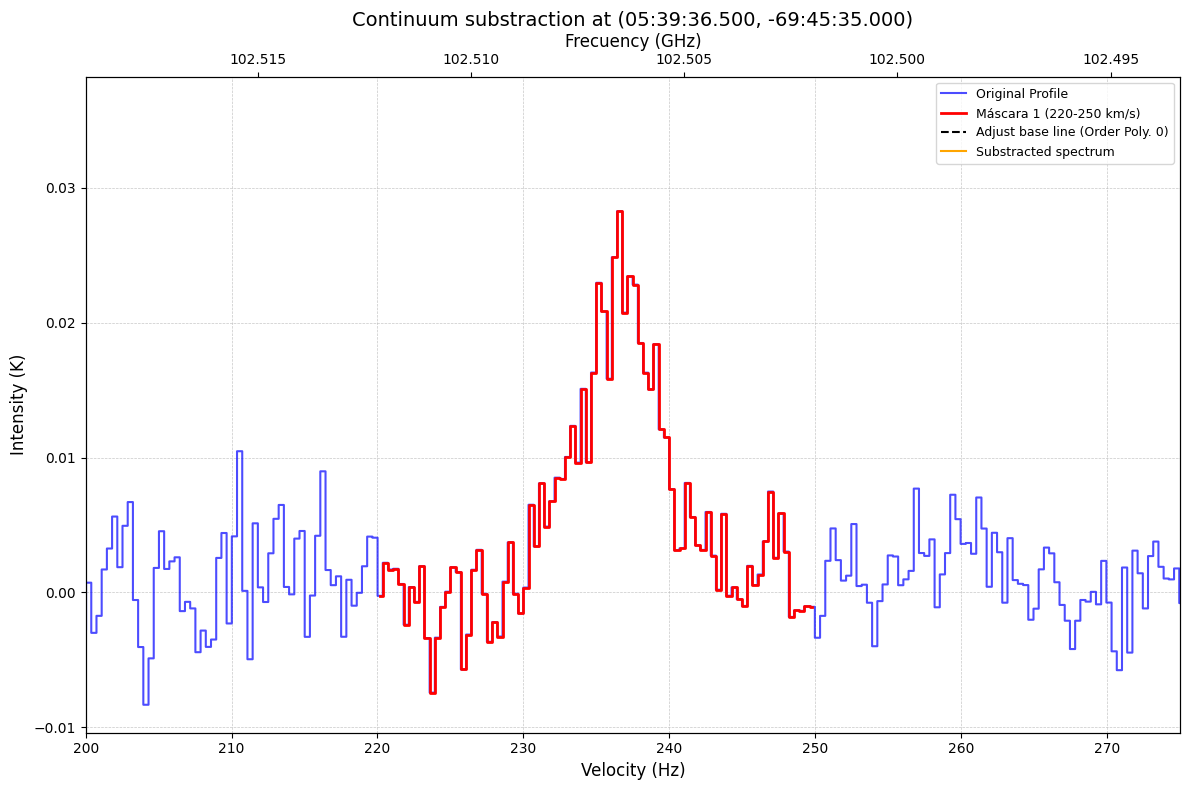


RMS (points adjusted to the continuum) for (05:39:36.500, -69:45:35.000): 0.00321 K
3$\sigma$ (points adjusted to the continuum) for (05:39:36.500, -69:45:35.000): 9.6353e-03 K


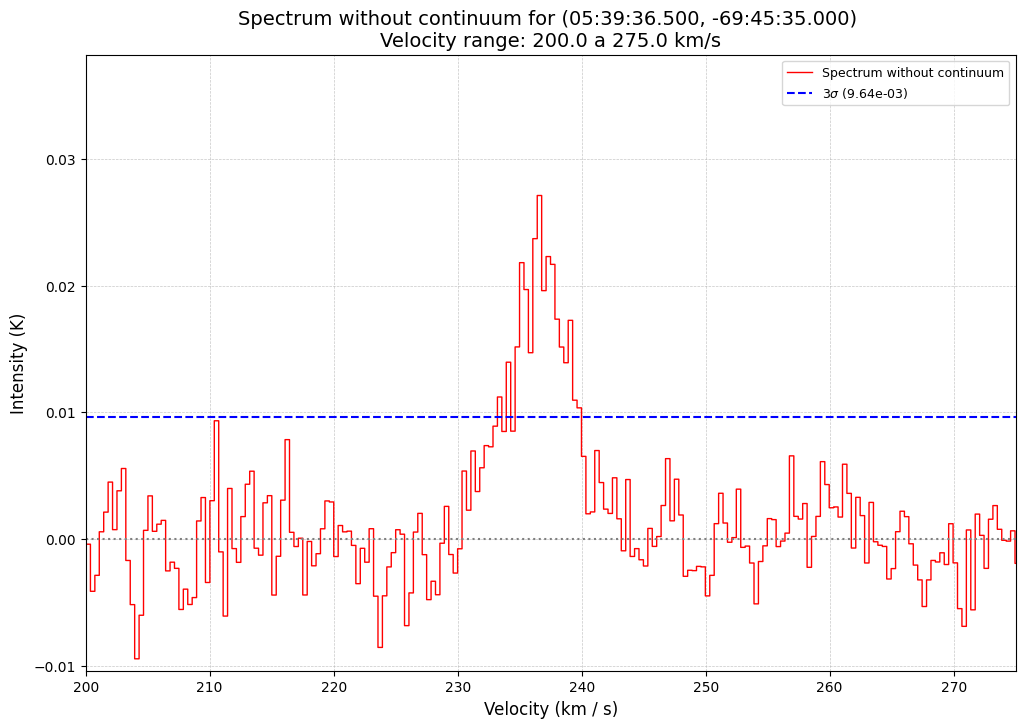

In [295]:
# You can change these (x_plot, y_plot) coordinates to any pixel you want to inspect
x_plot = x_pixel
y_plot = y_pixel
print(f'Coordenadas de píxel para plot: x={x_plot}, y={y_plot}')

intensity_original_plot = cube[:, y_plot, x_plot].value
intensity_subtracted_plot = hdu_residuals.data[:, y_plot, x_plot]


plt.figure(figsize=(12, 8))
# Plot original intensity profile
plt.step(VEL.value, intensity_original_plot, where='mid', label='Original Profile', color='blue', linestyle='-', linewidth=1.5, alpha=0.7)

# Plot the masked regions (lines excluded from fit)
colors = ['red', 'blue', 'green', 'purple'] # Cycle through colors for masks
for i, (v_min, v_max) in enumerate(mask_ranges_km_s):
    mask_plot_range = (VEL >= v_min * u.km/u.s) & (VEL <= v_max * u.km/u.s)
    plt.step(VEL[mask_plot_range].value, intensity_original_plot[mask_plot_range],
             where='mid', label=f'Máscara {i+1} ({v_min}-{v_max} km/s)',
             color=colors[i % len(colors)], linewidth=2)

# Plot the fitted continuum line
plt.plot(VEL.value, fitted_line_full, label=f'Adjust base line (Order Poly. {order})', color='black', linestyle='--', linewidth=1.5)

# Plot the continuum-subtracted spectrum (residuals)
plt.step(VEL.value, residuals_full, where='mid', label='Substracted spectrum', color='orange', linewidth=1.5)

plt.xlabel(f'Velocity ({UNIT})', fontsize=12)
plt.ylabel(f'Intensity ({cube.unit})', fontsize=12)
plt.title(f'Continuum substraction at ({ra_str}, {dec_str})', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='best', fontsize=9)

# Set x-limits for better visualization, based on the fit range
vel_min_plot_lim, vel_max_plot_lim = fit_range_km_s[0] * u.km/u.s, fit_range_km_s[1] * u.km/u.s
plt.xlim(vel_min_plot_lim.value, vel_max_plot_lim.value)

# Set Y-axis limits based on original intensity
if not np.all(np.isnan(intensity_original_plot)):
    plt.ylim(np.nanmin(intensity_original_plot) * 0.9, np.nanmax(intensity_original_plot) * 1.1)
    # plt.ylim(-1, 20)
else:
    # Fallback if original intensity is all NaNs
    plt.ylim(-0.1, 0.1) # A small default range if data is missing


# Add a second x-axis for frequency at the top
ax2 = plt.gca().twiny()
# Calculate corresponding frequencies for the velocity limits
freq_for_vel_max_plot = RESTFRQ * (1 - vel_max_plot_lim / C)
freq_for_vel_min_plot = RESTFRQ * (1 - vel_min_plot_lim / C)
ax2.set_xlim(freq_for_vel_min_plot.value, freq_for_vel_max_plot.value)
ax2.set_xlabel(f'Frecuency ({RESTFRQ.unit})', fontsize=12)

plt.tight_layout()
plt.show()


# --- Plotting: Residuals and RMS (for the plotted pixel) ---
# Calculate RMS from the residuals *only from the points used for fitting* (continuum-only)

three_sigma = 3 * rms_value        

print(f"\nRMS (points adjusted to the continuum) for ({ra_str}, {dec_str}): {rms_value:.5f} {cube.unit}") # of residuals 
print(f"3$\sigma$ (points adjusted to the continuum) for ({ra_str}, {dec_str}): {three_sigma:.4e} {cube.unit}")

plt.figure(figsize=(12, 8))
# Plot the full continuum-subtracted spectrum (which includes lines)
plt.step(VEL.value, intensity_subtracted_plot, where='mid', label='Spectrum without continuum', color='red', linewidth=1.0)
plt.axhline(0, color='grey', linestyle=':', linewidth=1.5)
            
if not np.isnan(three_sigma):
    plt.axhline(three_sigma, color='blue', linestyle='--', linewidth=1.5, label=f'3$\\sigma$ ({three_sigma:.2e})')
                

plt.xlabel(f'Velocity ({u.km/u.s})', fontsize=12)
plt.ylabel(f'Intensity ({cube.unit})', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='best', fontsize=9)
plt.title(f'Spectrum without continuum for ({ra_str}, {dec_str}) \nVelocity range: {fit_range_km_s[0]} a {fit_range_km_s[1]} km/s', fontsize=14)

plt.xlim(vel_min_plot_lim.value, vel_max_plot_lim.value)

# Set Y-axis limits based on original intensity
if not np.all(np.isnan(intensity_original_plot)):
    plt.ylim(np.nanmin(intensity_original_plot) * 0.9, np.nanmax(intensity_original_plot) * 1.1)
else:
    # Fallback if original intensity is all NaNs
    plt.ylim(-0.1, 0.1) # A small default range if data is missing

    # Add a second x-axis for frequency at the top for the residuals plot
    ax2_res = plt.gca().twiny()
    ax2_res.set_xlim(freq_for_vel_min_plot.value, freq_for_vel_max_plot.value)
    ax2_res.set_xlabel(f'Frecuency ({RESTFRQ.unit})', fontsize=12)
            
    plt.tight_layout()
    plt.show()





Coordenadas de píxel para plot: x=61, y=75


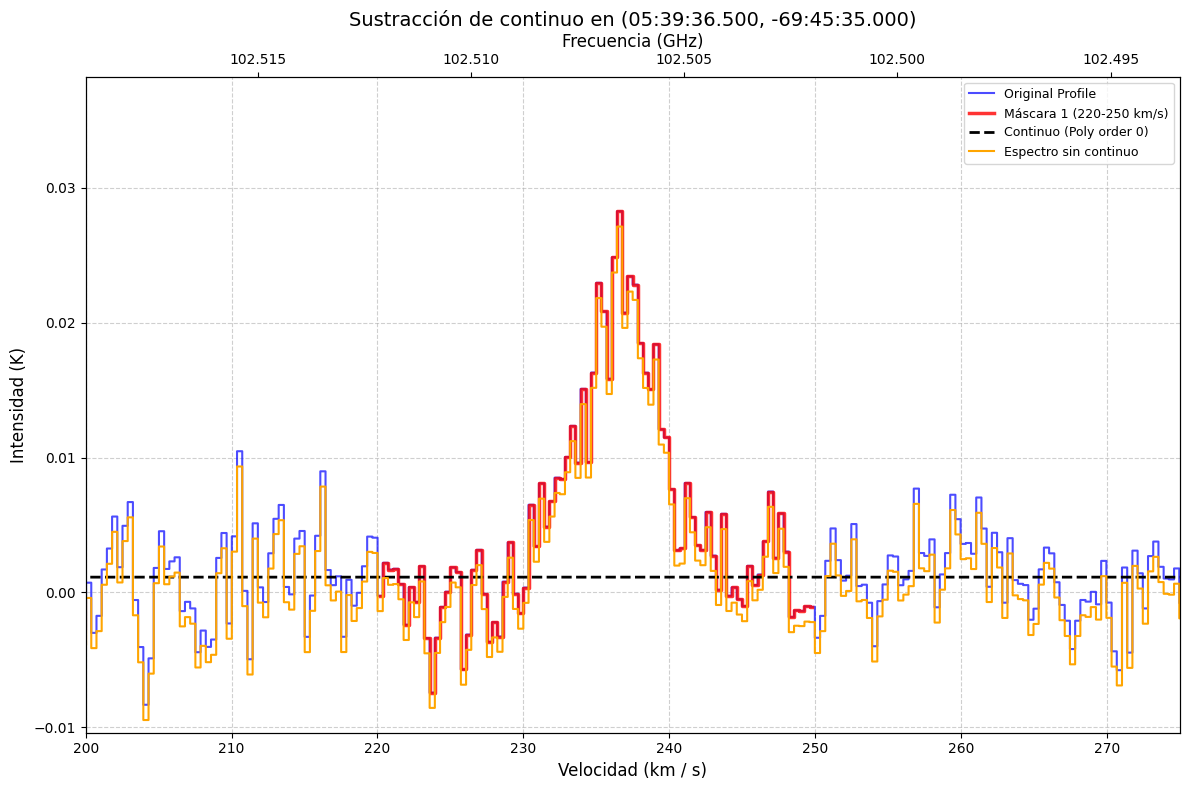

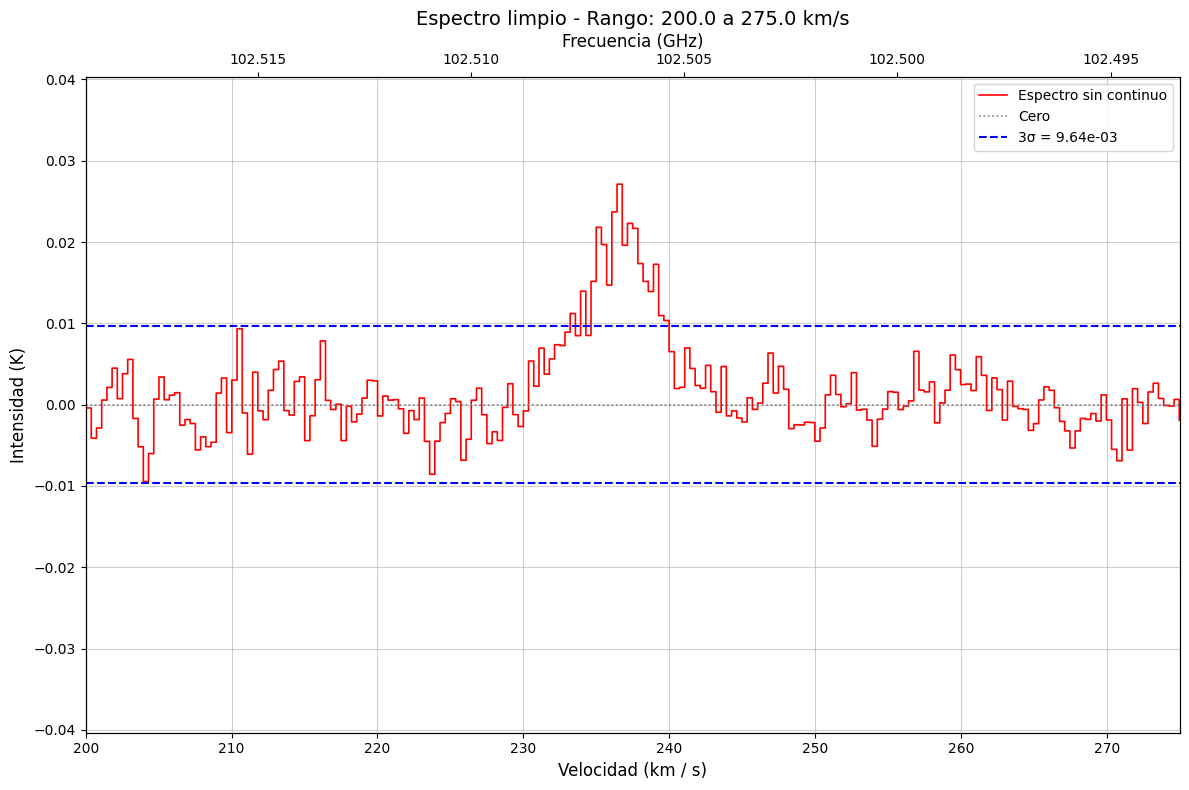


RMS (en canales de ajuste) para (05:39:36.500, -69:45:35.000): 0.00321 K
3σ = 9.6353e-03 K


In [296]:
# --- CONFIGURACIÓN DEL PÍXEL A PLOTEAR ---
x_plot = x_pixel
y_plot = y_pixel
print(f'Coordenadas de píxel para plot: x={x_plot}, y={y_plot}')

# --- EXTRAER DATOS DEL PÍXEL ---
intensity_original_plot = cube[:, y_plot, x_plot].value
intensity_subtracted_plot = continuum_subtracted_data[:, y_plot, x_plot]  # Desde tu cubo sustraído
rms_value = rms_map[y_plot, x_plot]  # RMS del píxel

# --- REAJUSTAR EL CONTINUO PARA ESTE PÍXEL (necesario para fitted_line_full) ---
intensities_to_fit = intensity_original_plot[include_chans]

if len(intensities_to_fit) > order and not np.isnan(rms_value):
    # Reajustar polinomio solo para este píxel
    poly_coeff = np.polyfit(velocities_to_fit.value, intensities_to_fit, deg=order)
    fitted_line_full = np.polyval(poly_coeff, VEL.value)  # ← ¡Ahora sí existe!
    residuals_full = intensity_original_plot - fitted_line_full
else:
    # En caso de fallo, usar ceros o NaNs
    fitted_line_full = np.zeros_like(VEL.value)
    residuals_full = intensity_original_plot.copy()
    rms_value = np.nan

three_sigma = 3 * rms_value

# ==============================================================
# GRÁFICO 1: Perfil original + continuo + sustraído
# ==============================================================
plt.figure(figsize=(12, 8))

# 1. Perfil original
plt.step(VEL.value, intensity_original_plot, where='mid', label='Original Profile', color='blue', linewidth=1.5, alpha=0.7)

# 2. Regiones enmascaradas (líneas excluidas)
colors = ['red', 'purple', 'green', 'orange']
for i, (v_min, v_max) in enumerate(mask_ranges_km_s):
    mask_plot = (VEL >= v_min * u.km/u.s) & (VEL <= v_max * u.km/u.s)
    plt.step(VEL[mask_plot].value, intensity_original_plot[mask_plot],
             where='mid', label=f'Máscara {i+1} ({v_min}-{v_max} km/s)',
             color=colors[i % len(colors)], linewidth=2.5, alpha=0.8)

# 3. Continuo ajustado
plt.plot(VEL.value, fitted_line_full, label=f'Continuo (Poly order {order})', color='black', linestyle='--', linewidth=2)

# 4. Espectro sustraído
plt.step(VEL.value, residuals_full, where='mid', label='Espectro sin continuo', color='orange', linewidth=1.5)

# Ejes y formato
plt.xlabel(f'Velocidad ({VEL.unit})', fontsize=12)
plt.ylabel(f'Intensidad ({cube.unit})', fontsize=12)
plt.title(f'Sustracción de continuo en ({ra_str}, {dec_str})', fontsize=14)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend(fontsize=9)

# Límites en X (rango de ajuste)
vel_min_plot, vel_max_plot = fit_range_km_s[0] * u.km/u.s, fit_range_km_s[1] * u.km/u.s
plt.xlim(vel_min_plot.value, vel_max_plot.value)

# Límites en Y
if not np.all(np.isnan(intensity_original_plot)):
    plt.ylim(np.nanmin(intensity_original_plot) * 0.9, np.nanmax(intensity_original_plot) * 1.1)
else:
    plt.ylim(-0.1, 0.1)

# Eje superior: frecuencia
ax2 = plt.gca().twiny()
freq_max = RESTFRQ * (1 - vel_max_plot / C)
freq_min = RESTFRQ * (1 - vel_min_plot / C)
ax2.set_xlim(freq_min.value, freq_max.value)
ax2.set_xlabel(f'Frecuencia ({RESTFRQ.unit})', fontsize=12)

plt.tight_layout()
plt.show()

# ==============================================================
# GRÁFICO 2: Solo el espectro sustraído + 3σ
# ==============================================================
plt.figure(figsize=(12, 8))

plt.step(VEL.value, intensity_subtracted_plot, where='mid', label='Espectro sin continuo', color='red', linewidth=1.2)
plt.axhline(0, color='gray', linestyle=':', linewidth=1.2, label='Cero')

if not np.isnan(three_sigma):
    plt.axhline(three_sigma, color='blue', linestyle='--', linewidth=1.5, label=f'3σ = {three_sigma:.2e}')
    plt.axhline(-three_sigma, color='blue', linestyle='--', linewidth=1.5)

plt.xlabel(f'Velocidad ({VEL.unit})', fontsize=12)
plt.ylabel(f'Intensidad ({cube.unit})', fontsize=12)
plt.title(f'Espectro limpio - Rango: {fit_range_km_s[0]} a {fit_range_km_s[1]} km/s', fontsize=14)
plt.grid(True, alpha=0.6)
plt.legend(fontsize=10)
plt.xlim(vel_min_plot.value, vel_max_plot.value)

# Límites en Y basados en el espectro sustraído
if not np.all(np.isnan(intensity_subtracted_plot)):
    ymax = np.nanmax(np.abs(intensity_subtracted_plot))
    plt.ylim(-ymax * 1.2, ymax * 1.2)
else:
    plt.ylim(-0.1, 0.1)

# Eje de frecuencia
ax2_res = plt.gca().twiny()
ax2_res.set_xlim(freq_min.value, freq_max.value)
ax2_res.set_xlabel(f'Frecuencia ({RESTFRQ.unit})', fontsize=12)

plt.tight_layout()
plt.show()

# ==============================================================
# IMPRIMIR RMS
# ==============================================================
print(f"\nRMS (en canales de ajuste) para ({ra_str}, {dec_str}): {rms_value:.5f} {cube.unit}")
print(f"3σ = {three_sigma:.4e} {cube.unit}")

### Uncertainty
To quantify the uncertainty into spectrum we using the Root mean square (RMS) noise (fluctuation level) is the total(average) noise level in the image which could be caused by antenna electronics as well as confusion. In general, it seems to be a noise(fluctuations) with gaussian distribution and so RMS noise seems to be synonimous to the standard deviation of that distribution. Lower noise means better interferometer sensitivity because it can detect fainter sources with lower noise. (ref: http://astro.vaporia.com/start/rms.html, https://en.wikipedia.org/wiki/Root_mean_square_deviation)

The RMS take the form: $ RMS = \sqrt{\frac{1}{N}\sum\limits^{N}_{i=1}({x_i}-{\={x}})^2} = \sigma $

where: 

- N is the count
- $ x_i $ are the values
- $ \={x} $ is the media values
in this case  the median isnt zero, can calculate the standar deviation (\sigma)

We know that to transform to FWHM to sigma, we have a conversion factor given by: 
$$ FWHM = \sigma \sqrt{8ln2} $$

(this is theorical/mathematical part)

----------------------------- PLOT THE HISTOGRAM VISUALIZATION -----------------------------------


Calculando y ploteando el mapa de RMS del ruido del continuo y el histograma para todo el cubo...


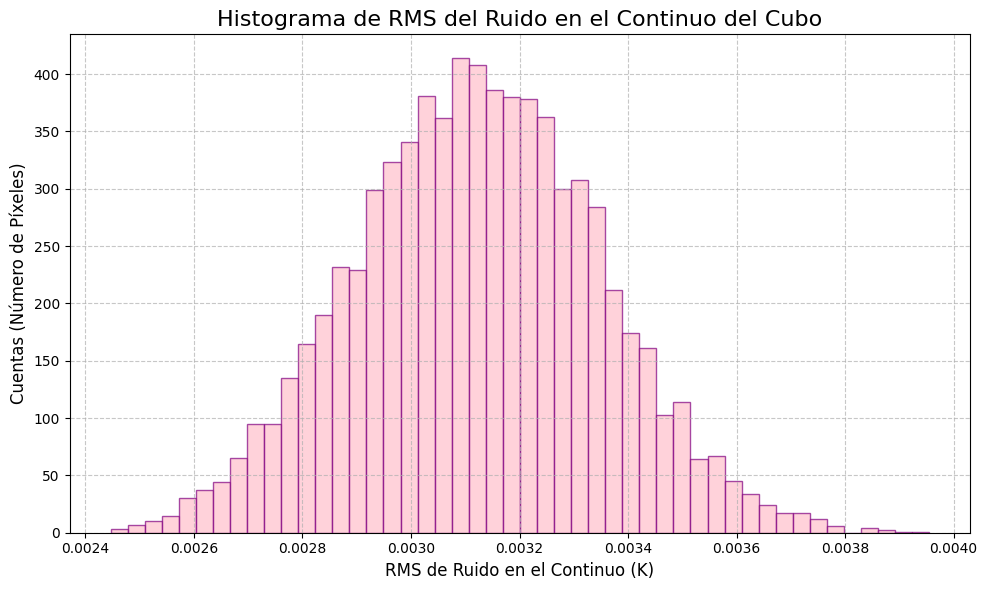

In [297]:

# --- RMS Histogram ---
print("\nCalculando y ploteando el mapa de RMS del ruido del continuo y el histograma para todo el cubo...")

# The rms_map_continuum_only is already calculated within the main processing loop

# --- Plotting: RMS Histogram ---
plt.figure(figsize=(10, 6))
# Flatten the rms_map_continuum_only and remove NaNs before plotting the histogram
rms_values_flat_continuum = rms_map[~np.isnan(rms_map)].flatten()

if rms_values_flat_continuum.size > 0:
    plt.hist(rms_values_flat_continuum, bins='auto', color='pink', edgecolor='purple', alpha=0.7)
    plt.xlabel(f'RMS de Ruido en el Continuo ({cube.unit})', fontsize=12)
    plt.ylabel('Cuentas (Número de Píxeles)', fontsize=12)
    plt.title('Histograma de RMS del Ruido en el Continuo del Cubo', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No hay valores RMS válidos del continuo para generar el histograma.")



------------------- Aplicacion de una gaussiana -----------------------

Rango de valores RMS: 0.002446 a 0.003955
Desviación estándar de los datos: 0.000225


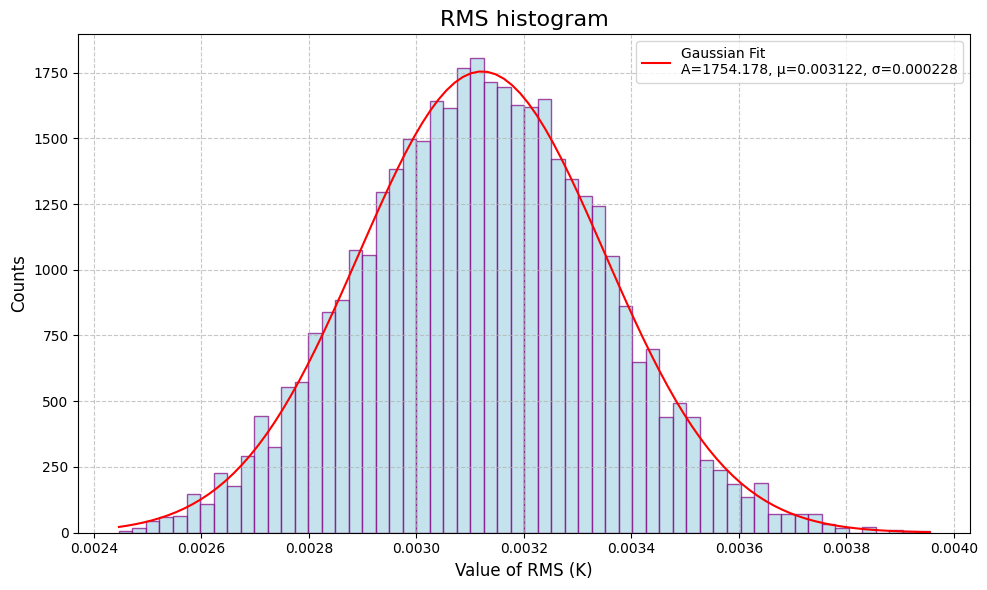

Parámetros de la gaussiana ajustada:
Amplitud (A): 1754.178
Media (μ): 0.003122
Desviación estándar (σ): 0.000228


In [300]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Definir la función gaussiana
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# --- Datos de entrada ---
rms_values_flat_continuum = rms_map[~np.isnan(rms_map)].flatten()

if rms_values_flat_continuum.size > 0:
    # Verificar el rango y la desviación estándar de los datos
    print(f"Rango de valores RMS: {np.min(rms_values_flat_continuum):.6f} a {np.max(rms_values_flat_continuum):.6f}")
    print(f"Desviación estándar de los datos: {np.std(rms_values_flat_continuum):.6f}")
    
    # Crear el histograma normalizado
    plt.figure(figsize=(10, 6))
    counts, bins, _ = plt.hist(rms_values_flat_continuum, bins=60, color='lightblue', edgecolor='purple', alpha=0.7, density=True)
    
    # Calcular los centros de los bins
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Estimaciones iniciales para los parámetros
    A_init = 1.0 / (np.sqrt(2 * np.pi) * np.std(rms_values_flat_continuum))  # Amplitud inicial para densidad
    mu_init = np.mean(rms_values_flat_continuum)
    sigma_init = np.std(rms_values_flat_continuum) * 1.0  # Ajustar según la dispersión
    
    # Ajustar la gaussiana
    try:
        popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=[A_init, mu_init, sigma_init], bounds=(0, [np.inf, np.inf, np.inf]))
        A_fit, mu_fit, sigma_fit = popt
        
        # Generar la curva ajustada
        x_fit = np.linspace(min(bins), max(bins), 100)
        y_fit = gaussian(x_fit, A_fit, mu_fit, sigma_fit)
        
        # Plotear el histograma y la curva ajustada
        plt.plot(x_fit, y_fit, 'r-', label=f'Gaussian Fit\nA={A_fit:.3f}, μ={mu_fit:.6f}, σ={sigma_fit:.6f}')
        plt.xlabel(f'Value of RMS (K)', fontsize=12)
        plt.ylabel('Counts', fontsize=12)
        plt.title('RMS histogram', fontsize=16)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Imprimir los parámetros ajustados
        print(f"Parámetros de la gaussiana ajustada:")
        print(f"Amplitud (A): {A_fit:.3f}")
        print(f"Media (μ): {mu_fit:.6f}")
        print(f"Desviación estándar (σ): {sigma_fit:.6f}")
        
    except RuntimeError as e:
        print(f"Error en el ajuste: {e}")
        print("Intenta ajustar los parámetros iniciales o revisar los datos.")
else:
    print("No hay valores RMS válidos del continuo para generar el histograma.")


-------------------------------------- Aplicaion de rayleight -----------------------


--- Datos del Ajuste de Rayleigh ---
Parámetro de Escala ($\sigma$): 5.0348e-04 K


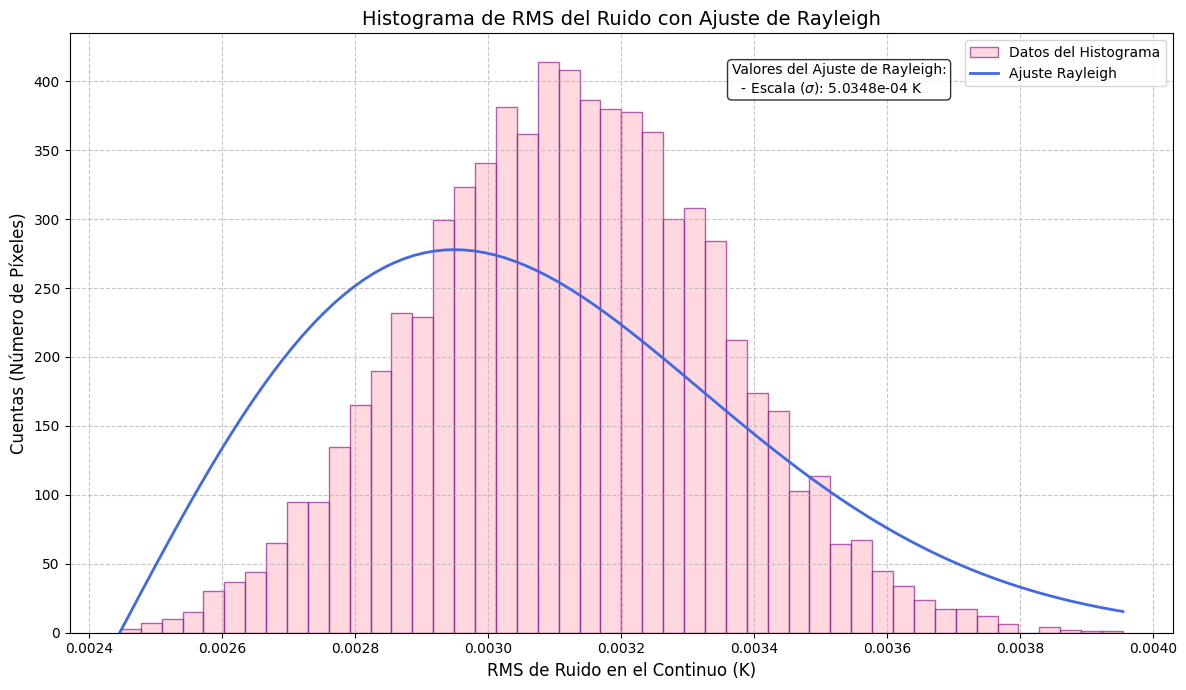

In [267]:
from scipy.optimize import curve_fit
from scipy.stats import rayleigh
# --- Plotting: RMS Histogram with Gaussian Fit ---
plt.figure(figsize=(12, 7))
if rms_values_flat_continuum.size > 0:
    # Plottear el histograma de los datos
    counts, bin_edges, _ = plt.hist(
        rms_values_flat_continuum, 
        bins='auto', 
        density=False, 
        color='pink', 
        edgecolor='purple', 
        alpha=0.6, 
        label='Datos del Histograma'
    )
    
    # Ajustar la distribución de Rayleigh a los datos
    try:
        # 'fit' encuentra los parámetros de la distribución que mejor se ajustan
        loc, scale = rayleigh.fit(rms_values_flat_continuum)

        # Generar la curva de la distribución ajustada
        x_fit = np.linspace(min(rms_values_flat_continuum), max(rms_values_flat_continuum), 100)
        # La función 'pdf' (Probability Density Function) da la forma de la curva
        pdf_rayleigh = rayleigh.pdf(x_fit, loc=loc, scale=scale)
        
        # Escalar la curva para que coincida con las alturas del histograma
        counts_scaled = pdf_rayleigh * len(rms_values_flat_continuum) * (bin_edges[1] - bin_edges[0])
        
        # Plotear la curva ajustada
        plt.plot(x_fit, counts_scaled, 'royalblue', linewidth=2, label=f'Ajuste Rayleigh')

        # Añadir un cuadro de texto con los parámetros importantes
        textstr = '\n'.join((
            f'Valores del Ajuste de Rayleigh:',
            f'  - Escala ($\\sigma$): {scale:.4e} {cube.unit}'
        ))
        
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        plt.text(0.6, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=props)

        print("\n--- Datos del Ajuste de Rayleigh ---")
        print(f"Parámetro de Escala ($\\sigma$): {scale:.4e} {cube.unit}")

    except Exception as e:
        print(f"El ajuste de Rayleigh falló: {e}")

    plt.xlabel(f'RMS de Ruido en el Continuo ({cube.unit})', fontsize=12)
    plt.ylabel('Cuentas (Número de Píxeles)', fontsize=12)
    plt.title('Histograma de RMS del Ruido con Ajuste de Rayleigh', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("No hay valores RMS válidos del continuo para generar el histograma.")

---------------------- calculate the median, moda -----------------

<>:63: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\s'
<>:65: SyntaxWarning: invalid escape sequence '\s'
<>:63: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\s'
<>:65: SyntaxWarning: invalid escape sequence '\s'
C:\Users\macka\AppData\Local\Temp\ipykernel_19956\3942706940.py:63: SyntaxWarning: invalid escape sequence '\s'
  print(f"$\sigma$(MAD) ={sigma_mad:.6e} {cube.unit}")
C:\Users\macka\AppData\Local\Temp\ipykernel_19956\3942706940.py:64: SyntaxWarning: invalid escape sequence '\s'
  print(f"$\sigma$ recortada (2–70%) = {sigma_trim:.6e} {cube.unit}")
C:\Users\macka\AppData\Local\Temp\ipykernel_19956\3942706940.py:65: SyntaxWarning: invalid escape sequence '\s'
  print(f"Umbral sugerido 3$\sigma$= {thr_3sigma:.6e} {cube.unit}")



Calculando y ploteando el mapa de RMS del continuo y el histograma con estimadores robustos...


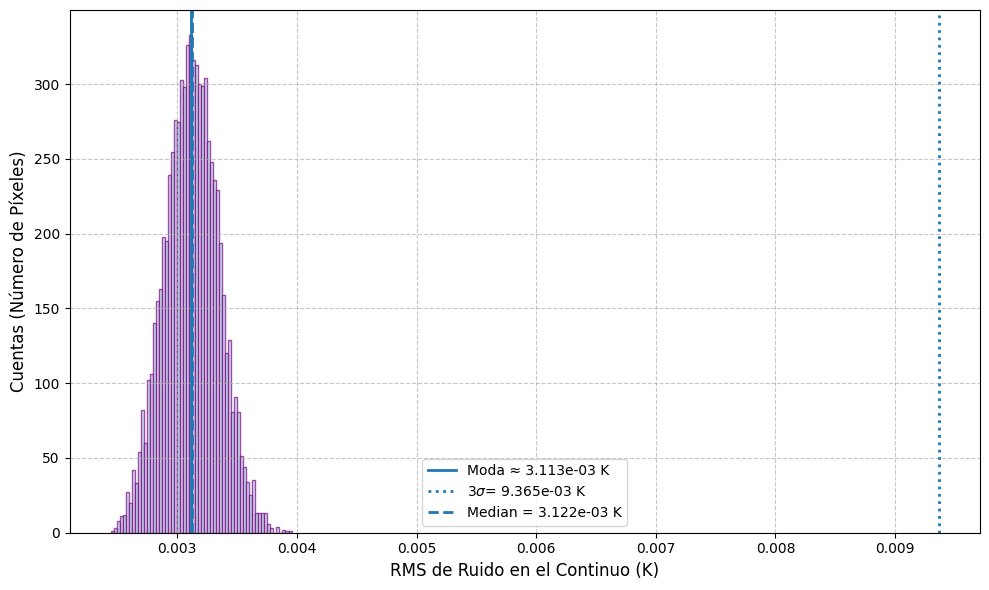


Estimadores del σ global (para umbralizar Moment-1, etc.):
  Moda ≈ 3.112755e-03 K
  Median = 3.121511e-03 K
$\sigma$(MAD) =2.277674e-04 K
$\sigma$ recortada (2–70%) = 1.420770e-04 K
Umbral sugerido 3$\sigma$= 9.364532e-03 K


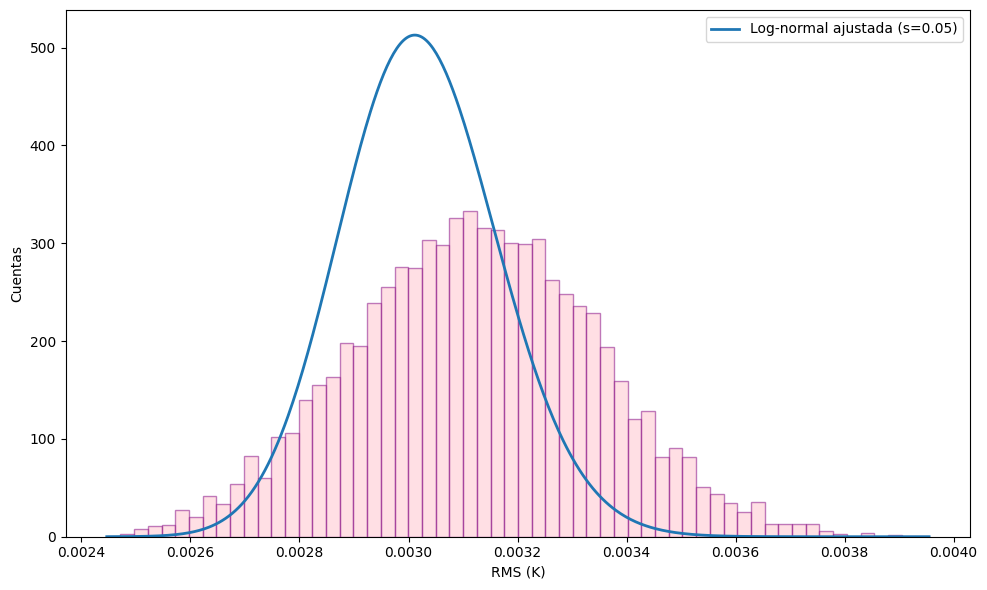

In [299]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import mad_std

print("\nCalculando y ploteando el mapa de RMS del continuo y el histograma con estimadores robustos...")

# Aplanar y limpiar
rms = rms_map[~np.isnan(rms_map)].ravel()

if rms.size == 0:
    print("No hay valores RMS válidos del continuo para generar el histograma.")
else:
    # ----------------- Histograma base -----------------
    counts, bin_edges = np.histogram(rms, bins=60)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    bin_width = np.diff(bin_edges).mean()

    # ----------------- Estimadores robustos -----------------
    # Moda aproximada = centro del bin con mayor conteo (pico del ruido)
    mode_idx = np.argmax(counts)
    moda = float(bin_centers[mode_idx])

    # Mediana y MAD
    media = float(np.mean(rms))
    median = float(np.median(rms))
    mad = float(np.mean(np.abs(rms - media)))
    sigma_mad = mad_std(rms, ignore_nan=True)  # estimador robusto de sigma

    # Recorte por percentiles para mitigar la cola alta (ajusta si lo ves necesario)
    p_low, p_high = np.percentile(rms, [2, 70])  # 2–70% suele funcionar bien en cubos ALMA
    rms_clip = rms[(rms >= p_low) & (rms <= p_high)]
    sigma_trim = float(np.std(rms_clip, ddof=1)) if rms_clip.size > 1 else float(np.std(rms, ddof=1))

    # σ (robusto): usa MAD
    thr_3sigma = 3.0 * median
    # ----------------- Plot -----------------
    plt.figure(figsize=(10, 6))
    plt.hist(rms, bins=bin_edges, color='lightblue', edgecolor='purple', alpha=0.7)
             #label='Histograma RMS')

    # Líneas de referencia
    plt.axvline(moda,    linestyle='-',  linewidth=2, label=f"Moda ≈ {moda:.3e} {cube.unit}")
    #plt.axvline(media, linestyle='-.', linewidth=2, label=f"Media = {media:.3e} {cube.unit}")
    #plt.axvline(sigma_mad, linestyle='-.', linewidth=2,
                #label=f"$\\sigma$(MAD) = {sigma_mad:.3e} {cube.unit}")
    plt.axvline(thr_3sigma, linestyle=':', linewidth=2,
                label=f"3$\\sigma$= {thr_3sigma:.3e} {cube.unit}")
    plt.axvline(median, linestyle='--', linewidth=2, label=f"Median = {median:.3e} {cube.unit}")



    plt.xlabel(f'RMS de Ruido en el Continuo ({cube.unit})', fontsize=12)
    plt.ylabel('Cuentas (Número de Píxeles)', fontsize=12)
    # plt.title('Histograma de RMS del Ruido en el Continuo del Cubo', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()

    print("\nEstimadores del σ global (para umbralizar Moment-1, etc.):")
    print(f"  Moda ≈ {moda:.6e} {cube.unit}")
    print(f"  Median = {median:.6e} {cube.unit}")
    print(f"$\sigma$(MAD) ={sigma_mad:.6e} {cube.unit}")
    print(f"$\sigma$ recortada (2–70%) = {sigma_trim:.6e} {cube.unit}")
    print(f"Umbral sugerido 3$\sigma$= {thr_3sigma:.6e} {cube.unit}")


    #
    from scipy.stats import lognorm
    # # Ajuste sobre el subconjunto recortado:
    s, loc, scale = lognorm.fit(rms_clip, floc=0)  # forzar loc=0 es habitual
    x = np.linspace(bin_edges.min(), bin_edges.max(), 500)
    pdf = lognorm.pdf(x, s=s, loc=loc, scale=scale)
    # # Escalar la PDF a cuentas:
    y = pdf * rms.size * bin_width
    plt.figure(figsize=(10,6))
    plt.hist(rms, bins=bin_edges, color='pink', edgecolor='purple', alpha=0.5)
    plt.plot(x, y, linewidth=2, label=f'Log-normal ajustada (s={s:.2f})')
    plt.xlabel(f'RMS ({cube.unit})'); plt.ylabel('Cuentas'); plt.legend(); plt.tight_layout(); plt.show()


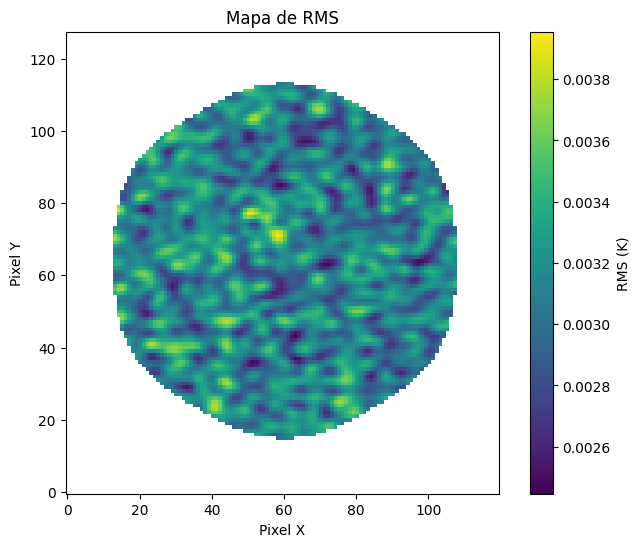

In [269]:
# Plot the RMS map
plt.figure(figsize=(8, 6))
plt.imshow(rms_map, origin='lower', cmap='viridis')
plt.colorbar(label=f'RMS ({cube.unit})')
plt.title('Mapa de RMS')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

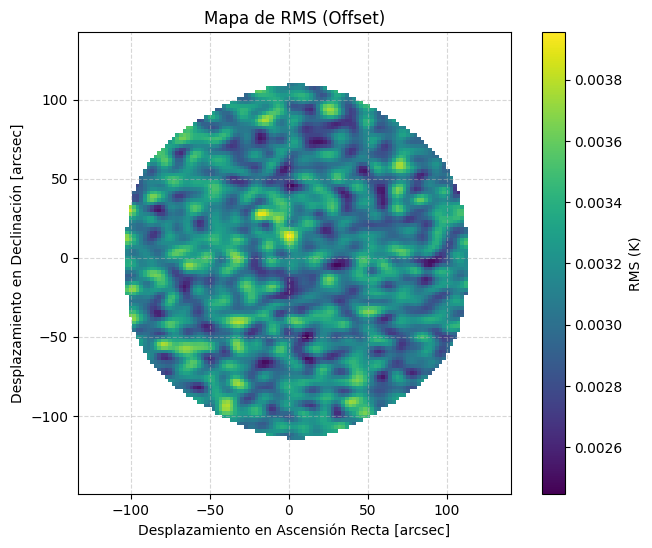

In [270]:
wcs = cube.wcs.celestial
wcs_celestial = wcs

# --- PASO 2: Calcular Coordenadas de Desplazamiento (Offset) ---
ny, nx = rms_map.shape
x_center_pix, y_center_pix = wcs.wcs.crpix # Obtener el punto de referencia en píxeles (CRPIX)

# Generar arrays de índices de píxeles
x_pix = np.arange(nx)
y_pix = np.arange(ny)

# Calcular el desplazamiento en píxeles con respecto al centro (CRPIX)
dx_pix = x_pix - x_center_pix
dy_pix = y_pix - y_center_pix

# Usar el tamaño de píxel (CDELT) para convertir el desplazamiento de píxeles a unidades angulares (grados)
# CDELT[0] es para el eje X (RA), CDELT[1] para el eje Y (Dec)
# Convertiremos a arcsec (segundos de arco): 1 grado = 3600 arcsec
dx_arcsec = dx_pix * wcs.wcs.cdelt[0] * 3600
dy_arcsec = dy_pix * wcs.wcs.cdelt[1] * 3600 # Nota: CDELT puede ser positivo o negativo

# Crear las mallas 2D de coordenadas de desplazamiento
X_offset_arcsec, Y_offset_arcsec = np.meshgrid(dx_arcsec, dy_arcsec)
# --- PASO 3: Graficar el Mapa RMS con Coordenadas de Desplazamiento ---
plt.figure(figsize=(8, 6))

# Usamos 'extent' para definir las coordenadas del mapa
# [x_min, x_max, y_min, y_max]
extent = [dx_arcsec.min(), dx_arcsec.max(), dy_arcsec.min(), dy_arcsec.max()]

plt.imshow(rms_map, 
           origin='lower', 
           cmap='viridis', 
           extent=extent) # <--- ¡Aquí está la clave!

# Generar la barra de color
plt.colorbar(label=f'RMS ({cube.unit if hasattr(cube, "unit") else "Unidad Desconocida"})')

# Títulos y Etiquetas
plt.title('Mapa de RMS (Offset)')
# Los ejes ahora muestran el desplazamiento
plt.xlabel('Desplazamiento en Ascensión Recta [arcsec]')
plt.ylabel('Desplazamiento en Declinación [arcsec]')

# Opcional: Centrar los ejes para que el origen (0,0) sea visible
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

## Agregar el cuadrado rojo de la oservacion solicitada a alma. 


In [271]:

coordinate = wcs_celestial
print(coordinate)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN' 'DEC--SIN' 
CRVAL : 84.90387208333 -69.76674222222 
CRPIX : 61.0 65.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.0006388888888889 0.0006388888888889 
NAXIS : 120  128


In [272]:
from astropy.coordinates import SkyCoord, SkyOffsetFrame
# Definir la coordenada central del rectángulo
center_coord = SkyCoord('05h39m36.6750s', '-69d46m00.260s', frame='icrs')  # position used in observation
# Definir el tamaño del rectángulo en segundos de arco
width_arcsec = 90 * u.arcsec
height_arcsec = 110 * u.arcsec

center_pixel_x, center_pixel_y = coordinate.world_to_pixel(center_coord)
print(f"Coordenadas del centro del rectángulo en píxeles: ({center_pixel_x}, {center_pixel_y})")

width_deg = width_arcsec.to(u.deg).value
height_deg = height_arcsec.to(u.deg).value
print(f"Ancho del rectángulo en grados: {width_deg}, Alto del rectángulo en grados: {height_deg}")

Coordenadas del centro del rectángulo en píxeles: (60.5735730139215, 64.00521241146888)
Ancho del rectángulo en grados: 0.025, Alto del rectángulo en grados: 0.030555555555555555


In [273]:
# Para convertir el ancho y alto de grados a píxeles,
# necesitamos la escala de píxeles de la WCS (grados por píxel).
# Si tu WCS tiene cdelt como grados/píxel, puedes usar eso.
# Supongamos que cdelt[0] es la escala en X y cdelt[1] en Y.
# Ten en cuenta que cdelt puede ser negativo. Usamos abs() para el tamaño.
pixel_scale_x_deg_per_pixel = np.abs(coordinate.wcs.cdelt[0])
pixel_scale_y_deg_per_pixel = np.abs(coordinate.wcs.cdelt[1])

width_pixels = width_deg / pixel_scale_x_deg_per_pixel
height_pixels = height_deg / pixel_scale_y_deg_per_pixel
print(f"Ancho del rectángulo en píxeles: {width_pixels}, Alto del rectángulo en píxeles: {height_pixels}")

Ancho del rectángulo en píxeles: 39.13043478260802, Alto del rectángulo en píxeles: 47.8260869565209


In [274]:
# El método Rectangle de Matplotlib espera la esquina inferior izquierda.
# Ajustamos desde el centro:
lower_left_x_pixel = center_pixel_x - (width_pixels / 2)
lower_left_y_pixel = center_pixel_y - (height_pixels / 2)

print(f"Esquina inferior izquierda del rectángulo en píxeles: ({lower_left_x_pixel}, {lower_left_y_pixel})")

Esquina inferior izquierda del rectángulo en píxeles: (41.008355622617486, 40.09216893320843)


In [275]:
center_ra_offset = (center_coord.ra.deg - ra_ref) * np.cos(np.deg2rad(dec_ref)) * 3600  # arcseconds
center_dec_offset = (center_coord.dec.deg - dec_ref) * 3600  # arcseconds

width_arcsec_value = width_arcsec.to(u.arcsec).value  # Ensure scalar value
height_arcsec_value = height_arcsec.to(u.arcsec).value  # Ensure scalar value
lower_left_ra_offset = center_ra_offset - (width_arcsec_value / 2)
lower_left_dec_offset = center_dec_offset - (height_arcsec_value / 2)

NameError: name 'ra_ref' is not defined

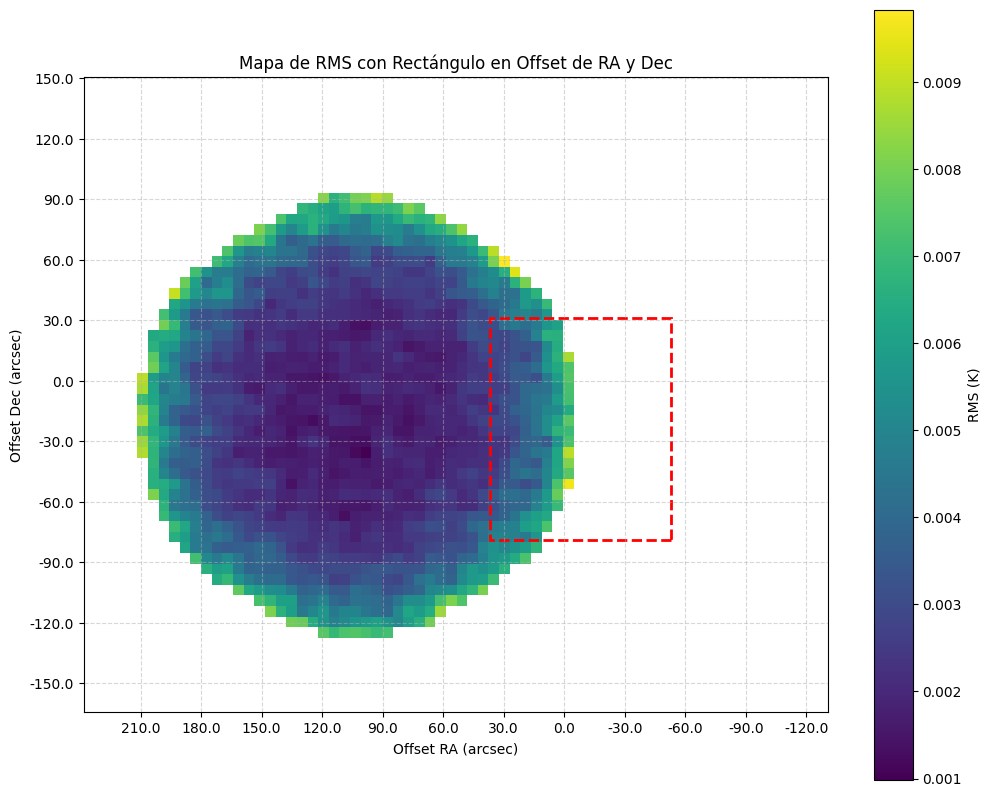

In [ ]:
from matplotlib.patches import Rectangle

# Create the figure
plt.figure(figsize=(12, 10))

# Plot the RMS map with offset axes
plt.imshow(rms_map, origin='lower', cmap='viridis',
           extent=[ra_offset.min(), ra_offset.max(), dec_offset.min(), dec_offset.max()])

# Add the rectangle in offset coordinates
rect = Rectangle(
    xy=(lower_left_ra_offset, lower_left_dec_offset),  # Lower-left corner in arcseconds
    width=width_arcsec_value, height=height_arcsec_value,  # Size in arcseconds
    edgecolor='red', facecolor='none', linewidth=2, linestyle='--'
)
plt.gca().add_patch(rect)

# Add colorbar
plt.colorbar(label=f'RMS ({cube.unit})')


# Define tick locations (e.g., every 10 arcseconds)
ra_tick_spacing = 30  # arcseconds
dec_tick_spacing = 30  # arcseconds
ra_ticks = np.arange(np.ceil(ra_offset.min() / ra_tick_spacing) * ra_tick_spacing,
                     np.floor(ra_offset.max() / ra_tick_spacing) * ra_tick_spacing + ra_tick_spacing,
                     ra_tick_spacing)
dec_ticks = np.arange(np.ceil(dec_offset.min() / dec_tick_spacing) * dec_tick_spacing,
                      np.floor(dec_offset.max() / dec_tick_spacing) * dec_tick_spacing + dec_tick_spacing,
                      dec_tick_spacing)

# Set ticks and labels
plt.xticks(ra_ticks, labels=[f'{tick:.1f}' for tick in ra_ticks])
plt.yticks(dec_ticks, labels=[f'{tick:.1f}' for tick in dec_ticks])

# Add grid
plt.grid(True, linestyle='--', alpha=0.5)

# Axis labels
plt.xlabel('Offset RA (arcsec)')
plt.ylabel('Offset Dec (arcsec)')

# Title
plt.title('Mapa de RMS con Rectángulo en Offset de RA y Dec')

# Invert RA axis (astronomical convention: RA increases to the left)
plt.gca().invert_xaxis()

# Show the plot
plt.show()